In [100]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt

In [83]:
from sklearn.metrics import mean_absolute_error, r2_score

In [92]:
def get_raw_df():
    return pd.read_csv(r"C:\Users\91910\Desktop\IIT_Kanpur\Semester6\MSE643A\Project\bandGap\dielectric_constant_data.csv")

def get_propsFromStruct(df): #returns len, angles and periodic properties of a crystal structure for all compounds
    structure_arr = []

    for struct in df['structure']:
        finalStruct_arr = []
        modLen_arr = []
        modAngl_arr = []
        #modPerio_arr = []
        split_arr = struct.split('\n')
        len_arr = split_arr[2].split()[2:]
        angl_arr = split_arr[3].split()[1:]
        #perio_arr = split_arr[4].split()[2:]
        for i in range(3):
            modLen_arr.append(float(len_arr[i]))
            modAngl_arr.append(float(angl_arr[i]))
        for ele in modLen_arr:
            finalStruct_arr.append(ele)
        for ele in modAngl_arr:
            finalStruct_arr.append(ele)
#         for ele in perio_arr:
#             finalStruct_arr.append(ele)
        structure_arr.append(finalStruct_arr)
        
    return np.array(structure_arr)

def transform_raw_e_electronic(df): #transforms e_electronic into model readable values
    res = []
    for tensor_per_struct in df['e_electronic']:
        tensor_split = tensor_per_struct[2:-2].split(',')
        for i in range(len(tensor_split)):
            if (i==2 or i==5):
                tensor_split[i] = tensor_split[i].strip()[:-1]
            elif (i==3 or i==6):
                tensor_split[i] = tensor_split[i].strip()[1:]
        for j in range(len(tensor_split)):
            tensor_split[j] = float(tensor_split[j])
        res.append(tensor_split)
    return np.array(res)

def transform_raw_e_total(df): #transforms e_total into model readable values
    res = []
    for tensor_per_struct in df['e_total']:
        tensor_split = tensor_per_struct[2:-2].split(',')
        for i in range(len(tensor_split)):
            if (i==2 or i==5):
                tensor_split[i] = tensor_split[i].strip()[:-1]
            elif (i==3 or i==6):
                tensor_split[i] = tensor_split[i].strip()[1:]
        for j in range(len(tensor_split)):
            tensor_split[j] = float(tensor_split[j])
        res.append(tensor_split)
    return np.array(res)

def get_mod_df():
    raw_df = get_raw_df()
    mod_df = raw_df.copy()
    mod_df.drop(raw_df.columns[[0,1,2,6,8,9,14,15,16]], inplace= True, axis= 1)
    transformed_e_electronic = transform_raw_e_electronic(raw_df)
    transformed_e_total = transform_raw_e_total(raw_df)
    propsFromStruct_arr = get_propsFromStruct(raw_df)
    for i in range(9):
        mod_df['e_e_' + str(i)] = transformed_e_electronic[:, i]
    for i in range(9):
        mod_df['e_t_' + str(i)] = transformed_e_total[:, i]
    mod_df['len_a'] = propsFromStruct_arr[:,0]
    mod_df['len_b'] = propsFromStruct_arr[:,1]
    mod_df['len_c'] = propsFromStruct_arr[:,2]
    mod_df['angl_alpha'] = propsFromStruct_arr[:,3]
    mod_df['angl_beta'] = propsFromStruct_arr[:,4]
    mod_df['angl_gamma'] = propsFromStruct_arr[:,5]
    return mod_df

def transform_boolData(df, col_name): #1d array must be given
    le = LabelEncoder()
    df[col_name] = le.fit_transform(df[col_name])
    
def normal_split(df, test_size, shuffle):
    X = df.drop('band_gap', axis=1)
    y = df['band_gap']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=shuffle)
    
    return (X_train, X_test, y_train, y_test)

def evaluate_metrics(y_test, y_preds):
    r2 = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    evs = explained_variance_score(y_test, y_preds)

#     print('r2 score is ', r2)
#     print('mean absolute error is ', mae)
#     print('explained variance score is ', evs)
    
    return (r2, mae)

In [85]:
get_raw_df()

,Unnamed: 0,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
0,0,mp-441,Rb2Te,3,225,159.501208,Full Formula (Rb2 Te1)\nReduced Formula: Rb2Te...,1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...
1,1,mp-22881,CdCl2,3,166,84.298097,Full Formula (Cd1 Cl2)\nReduced Formula: CdCl2...,3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...
2,2,mp-28013,MnI2,3,164,108.335875,Full Formula (Mn1 I2)\nReduced Formula: MnI2\n...,1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...
3,3,mp-567290,LaN,4,186,88.162562,Full Formula (La2 N2)\nReduced Formula: LaN\na...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...
4,4,mp-560902,MnF2,6,136,82.826401,Full Formula (Mn2 F4)\nReduced Formula: MnF2\n...,2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,1051,mp-568032,Cd(InSe2)2,7,111,212.493121,Full Formula (Cd1 In2 Se4)\nReduced Formula: C...,0.87,"[[7.74896783, 0.0, 0.0], [0.0, 7.74896783, 0.0...","[[11.85159471, 1e-08, 0.0], [1e-08, 11.8515962...",2.77,7.67,11.76,True,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 In2 Se4\n1.0\n5.912075 0.000000 0.000000\n...
1052,1052,mp-696944,LaHBr2,8,194,220.041363,Full Formula (La2 H2 Br4)\nReduced Formula: La...,3.60,"[[4.40504391, 6.1e-07, 0.0], [6.1e-07, 4.40501...","[[8.77136355, 1.649999999999999e-06, 0.0], [1....",2.00,3.99,7.08,True,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 H2 Br4\n1.0\n4.137833 0.000000 0.000000\n-...
1053,1053,mp-16238,Li2AgSb,4,216,73.882306,Full Formula (Li2 Ag1 Sb1)\nReduced Formula: L...,0.14,"[[212.60750153, -1.843e-05, 0.0], [-1.843e-05,...","[[232.59707383, -0.0005407400000000001, 0.0025...",14.58,212.61,232.60,True,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Li2 Ag1 Sb1\n1.0\n4.078957 0.000000 2.354987\n...
1054,1054,mp-4405,Rb3AuO,5,221,177.269065,Full Formula (Rb3 Au1 O1)\nReduced Formula: Rb...,0.21,"[[6.40511712, 0.0, 0.0], [0.0, 6.40511712, 0.0...","[[22.43799785, 0.0, 0.0], [0.0, 22.4380185, 0....",2.53,6.41,22.44,True,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb3 Au1 O1\n1.0\n5.617516 0.000000 0.000000\n0...


In [86]:
mod_df = get_mod_df()

mod_df.head()

,nsites,space_group,volume,band_gap,n,poly_electronic,poly_total,pot_ferroelectric,e_e_0,e_e_1,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
0,3,225,159.501208,1.88,1.86,3.44,6.23,False,3.441158,-0.000031,...,0.000025,-0.000095,0.000022,6.235207,6.087322,6.087322,6.087323,60.000003,60.000002,59.999999
1,3,166,84.298097,3.52,1.78,3.16,6.73,False,3.346884,-0.044985,...,-0.904664,-1.463589,-0.904660,3.945366,6.710024,6.710024,6.710023,34.019895,34.019897,34.019896
2,3,164,108.335875,1.17,2.23,4.97,10.64,False,5.543085,-0.000005,...,0.000444,0.000123,0.000442,4.315681,4.158086,4.158086,7.235270,90.000000,90.000000,120.000001
3,4,186,88.162562,1.12,2.65,7.04,17.99,False,7.093167,0.000008,...,0.020643,-0.008708,0.017618,20.396643,4.132865,4.132865,5.960067,90.000000,90.000000,119.999995
4,6,136,82.826401,2.87,1.53,2.35,7.12,False,2.423962,0.000075,...,0.013442,0.001279,0.014417,7.459124,3.354588,4.968952,4.968952,90.000000,90.000000,90.000000


In [87]:
transform_boolData(mod_df, 'pot_ferroelectric')

In [88]:
mod_df

,nsites,space_group,volume,band_gap,n,poly_electronic,poly_total,pot_ferroelectric,e_e_0,e_e_1,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
0,3,225,159.501208,1.88,1.86,3.44,6.23,0,3.441158,-3.097000e-05,...,2.481000e-05,-0.000095,2.175000e-05,6.235207,6.087322,6.087322,6.087323,60.000003,60.000002,59.999999
1,3,166,84.298097,3.52,1.78,3.16,6.73,0,3.346884,-4.498543e-02,...,-9.046643e-01,-1.463589,-9.046600e-01,3.945366,6.710024,6.710024,6.710023,34.019895,34.019897,34.019896
2,3,164,108.335875,1.17,2.23,4.97,10.64,0,5.543085,-5.280000e-06,...,4.435100e-04,0.000123,4.420300e-04,4.315681,4.158086,4.158086,7.235270,90.000000,90.000000,120.000001
3,4,186,88.162562,1.12,2.65,7.04,17.99,0,7.093167,7.990000e-06,...,2.064269e-02,-0.008708,1.761772e-02,20.396643,4.132865,4.132865,5.960067,90.000000,90.000000,119.999995
4,6,136,82.826401,2.87,1.53,2.35,7.12,0,2.423962,7.452000e-05,...,1.344158e-02,0.001279,1.441676e-02,7.459124,3.354588,4.968952,4.968952,90.000000,90.000000,90.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,7,111,212.493121,0.87,2.77,7.67,11.76,1,7.748968,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,11.562826,5.912075,5.912075,6.079460,90.000000,90.000000,90.000000
1052,8,194,220.041363,3.60,2.00,3.99,7.08,1,4.405044,6.100000e-07,...,-1.000000e-08,0.000000,-1.000000e-08,3.696193,4.137833,4.137856,14.839681,90.000000,90.000000,119.999810
1053,4,216,73.882306,0.14,14.58,212.61,232.60,1,212.607502,-1.843000e-05,...,1.830120e-03,0.002588,1.830120e-03,232.596394,4.709974,4.709973,4.709974,59.999995,59.999999,60.000000
1054,5,221,177.269065,0.21,2.53,6.41,22.44,1,6.405117,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,22.438270,5.617516,5.617516,5.617516,90.000000,90.000000,90.000000


In [89]:
mod_df.describe()

,nsites,space_group,volume,band_gap,n,poly_electronic,poly_total,pot_ferroelectric,e_e_0,e_e_1,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
count,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,...,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000
mean,7.530303,142.970644,166.420376,2.119432,2.434886,7.248049,14.777898,0.671402,7.789275,0.007547,...,-0.041765,-0.039766,-0.041609,13.466755,5.327309,5.633317,7.074054,82.243515,81.881675,86.212840
std,3.388443,67.264591,97.425084,1.604924,1.148849,13.054947,19.435303,0.469926,16.682064,0.150892,...,0.482749,0.608666,0.482767,16.524370,1.652422,1.753111,2.748443,22.651641,22.241797,26.675765
min,2.000000,1.000000,13.980548,0.110000,1.280000,1.630000,2.080000,0.000000,1.630283,-1.312264,...,-2.903855,-3.049340,-2.903852,1.768598,2.511976,2.511976,2.704040,9.976622,9.976620,9.976624
25%,5.000000,82.000000,96.262337,0.890000,1.770000,3.130000,7.557500,0.000000,3.081929,-0.000030,...,-0.001202,-0.000803,-0.001244,6.733744,4.193715,4.433480,5.433825,60.000003,60.000002,60.000003
50%,8.000000,163.000000,145.944691,1.730000,2.190000,4.790000,10.540000,1.000000,4.890308,0.000000,...,0.000000,0.000000,0.000000,9.659749,5.111274,5.472977,6.556760,90.000000,90.000000,90.000000
75%,9.000000,194.000000,212.106405,2.885000,2.730000,7.440000,15.482500,1.000000,7.868094,0.000034,...,0.001025,0.000674,0.000754,14.312478,6.085025,6.365154,7.773563,90.000000,90.000000,110.067041
max,20.000000,229.000000,597.341134,8.320000,16.030000,256.840000,277.780000,1.000000,380.755434,1.802489,...,3.071309,7.111987,3.071309,232.596394,17.799815,19.172774,31.512556,148.229324,148.229324,146.832566


In [66]:
X_train, X_test, y_train, y_test = normal_split(mod_df, 0.15, True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train.head()

(897, 31)
(897,)
(159, 31)
(159,)


,nsites,space_group,volume,n,poly_electronic,poly_total,pot_ferroelectric,e_e_0,e_e_1,e_e_2,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
12,3,225,69.537895,2.23,4.97,8.42,0,4.967592,0.000034,-0.000012,...,-0.000104,-0.000156,-0.000104,8.423227,4.615785,4.615784,4.615784,60.000001,60.000005,60.000003
307,12,189,343.822654,2.73,7.48,12.79,0,6.460945,0.000078,-0.000043,...,-0.000164,-0.000037,-0.000113,16.965765,8.100385,8.100386,6.050517,90.000000,90.000000,120.000000
371,14,15,191.599724,1.65,2.71,5.99,0,2.687373,-0.100676,-0.011132,...,0.739360,0.674820,0.739343,6.151129,5.534123,5.534123,7.312596,68.035217,68.035221,87.064735
914,7,82,189.718519,2.73,7.44,11.06,1,7.430698,0.013192,0.022335,...,0.079634,0.063575,0.079629,11.122676,5.875322,5.875322,6.889534,115.238976,115.238979,89.999999
290,8,176,349.831956,1.49,2.22,2.37,1,2.404893,-0.000066,-0.000035,...,0.000014,-0.000003,0.000009,1.853091,7.000120,7.000121,8.243618,90.000000,90.000000,120.000006


In [101]:
def train_test_split_analysis(model, df):
    output = []
    for test_size in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        X_train, X_test, y_train, y_test = normal_split(df, test_size, True)
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        r2, mae = evaluate_metrics(y_test, y_preds)
        output.append((r2, mae))
    r2_scores = []
    mae_scores = []
    for tup in output:
        r2_scores.append(tup[0])
        mae_scores.append(tup[1])
    return r2_scores, mae_scores

In [103]:
model = svm.SVR()
svr_r2_scores, svr_mae_scores = train_test_split_analysis(model, mod_df)

In [104]:
model = DecisionTreeRegressor()
DT_r2_scores, DT_mae_scores = train_test_split_analysis(model, mod_df)

In [105]:
model = RandomForestRegressor()
RF_r2_scores, RF_mae_scores = train_test_split_analysis(model, mod_df)

In [107]:
model = GradientBoostingRegressor()
GB_r2_scores, GB_mae_scores = train_test_split_analysis(model, mod_df)

In [108]:
model = KNeighborsRegressor()
KNN_r2_scores, KNN_mae_scores = train_test_split_analysis(model, mod_df)

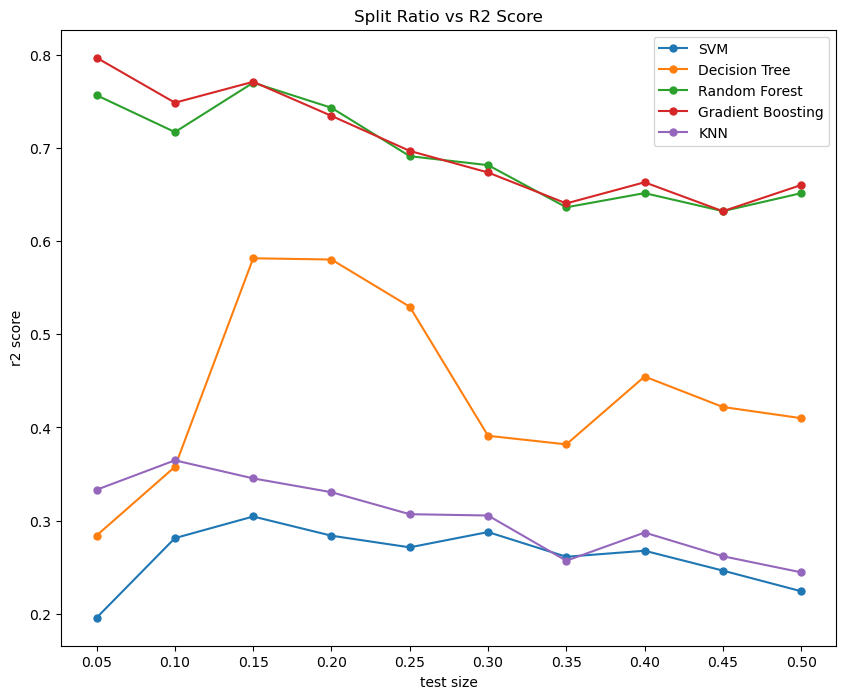

In [123]:
plt.figure(figsize=(10, 8))
test_size = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
plt.plot(test_size, svr_r2_scores, label='SVM', marker='o', markersize=5.0)
plt.plot(test_size, DT_r2_scores, label='Decision Tree', marker='o',  markersize=5.0)
plt.plot(test_size, RF_r2_scores, label='Random Forest', marker='o',  markersize=5.0)
plt.plot(test_size, GB_r2_scores, label='Gradient Boosting', marker='o',  markersize=5.0)
plt.plot(test_size, KNN_r2_scores, label='KNN', marker='o',  markersize=5.0)

plt.xticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
plt.title('Split Ratio vs R2 Score')
plt.xlabel('test size')
plt.ylabel('r2 score')
plt.legend()
plt.show()

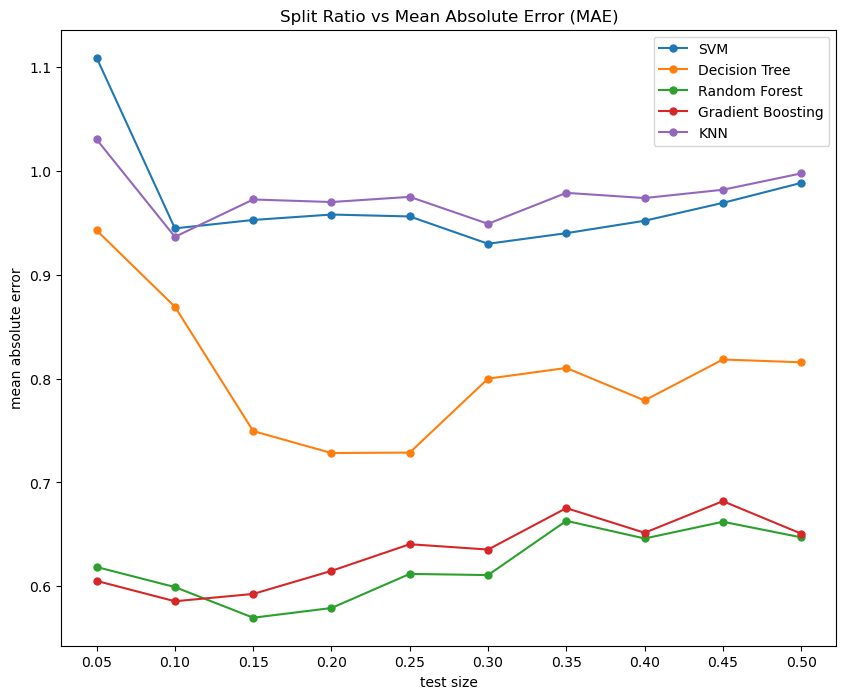

In [124]:
plt.figure(figsize=(10, 8))
test_size = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
plt.plot(test_size, svr_mae_scores, label='SVM', marker='o', markersize=5.0)
plt.plot(test_size, DT_mae_scores, label='Decision Tree', marker='o',  markersize=5.0)
plt.plot(test_size, RF_mae_scores, label='Random Forest', marker='o',  markersize=5.0)
plt.plot(test_size, GB_mae_scores, label='Gradient Boosting', marker='o',  markersize=5.0)
plt.plot(test_size, KNN_mae_scores, label='KNN', marker='o',  markersize=5.0)

plt.xticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
plt.title('Split Ratio vs Mean Absolute Error (MAE)')
plt.xlabel('test size')
plt.ylabel('mean absolute error')
plt.legend()
plt.show()

In [67]:
type(y_train)

pandas.core.series.Series

In [15]:
X_train.to_csv(r"C:\Users\91910\Desktop\IIT_Kanpur\Semester 6\MSE643A\Project\bandGap\X_train.csv")
y_train.to_csv(r"C:\Users\91910\Desktop\IIT_Kanpur\Semester 6\MSE643A\Project\bandGap\y_train.csv")

X_test.to_csv(r"C:\Users\91910\Desktop\IIT_Kanpur\Semester 6\MSE643A\Project\bandGap\X_test.csv")
y_test.to_csv(r"C:\Users\91910\Desktop\IIT_Kanpur\Semester 6\MSE643A\Project\bandGap\y_test.csv")

In [68]:
regr1 = svm.SVR()
regr1.fit(X_train, y_train)
y_preds1 = regr1.predict(X_test)

y_preds1

array([ 1.32505324,  2.04400133,  2.12989669,  2.14062634,  1.8733715 ,
        1.18834293,  1.02203949,  1.20475687,  2.03304288,  2.46024306,
        2.4117533 ,  1.81047348,  2.58495033,  2.43061546,  2.21241639,
        2.46171405,  0.53460646,  0.61092189,  1.40416249,  1.10633377,
        2.26677095,  2.24071518,  1.5920737 ,  1.6528725 ,  1.36383545,
        1.83216613,  1.59815083,  1.83845398,  2.67095566,  1.46171512,
        1.15532754,  2.42795947,  2.54007221,  1.34205074,  1.86587113,
        1.2308261 ,  2.31886229,  2.70868676,  2.1867669 ,  1.56277421,
        1.2022278 ,  1.32470267,  2.31007731,  2.49295326,  2.42966783,
        2.02478858,  0.41406009,  2.12587306,  2.31431375,  2.1722515 ,
        2.65567104,  2.23583432,  0.60325465,  0.88841245,  1.89008129,
        1.37003931,  1.58386813,  1.57766065,  0.27438789,  1.31860907,
        2.13513351,  1.51654763,  2.53444137,  1.10230284,  1.42014318,
        1.84491187,  2.23022671,  2.52746228,  1.66189423,  1.83

In [69]:
#for Support Vector Regressor
evaluate_metrics(y_test, y_preds1)

r2 score is  0.30448432606676135
mean absolute error is  0.9528828404894137
explained variance score is  0.34270871366592937


In [70]:
regr2 = DecisionTreeRegressor()
regr2.fit(X_train, y_train)

y_preds2 = regr2.predict(X_test)

y_preds2

array([0.97, 0.24, 1.7 , 4.77, 1.17, 0.65, 3.2 , 0.83, 1.59, 1.96, 0.24,
       0.56, 5.8 , 4.93, 2.65, 5.5 , 0.27, 0.11, 2.68, 0.15, 2.13, 3.14,
       1.38, 1.2 , 1.84, 3.06, 3.63, 3.05, 7.26, 0.86, 0.23, 4.68, 5.34,
       0.4 , 1.88, 1.14, 6.88, 2.82, 1.42, 2.65, 0.62, 1.07, 5.34, 3.09,
       2.41, 0.59, 0.43, 0.66, 6.88, 0.58, 3.15, 3.62, 0.2 , 0.82, 2.88,
       1.07, 0.85, 0.74, 0.37, 1.25, 2.25, 1.5 , 6.23, 3.2 , 1.19, 2.02,
       2.87, 4.88, 2.21, 1.93, 1.25, 4.65, 1.1 , 0.67, 0.96, 0.58, 2.05,
       1.  , 1.88, 1.17, 0.17, 0.23, 3.06, 2.06, 1.85, 4.17, 0.4 , 2.03,
       4.07, 1.56, 2.44, 5.  , 1.46, 0.23, 0.64, 2.25, 6.79, 0.36, 0.57,
       1.73, 0.58, 4.93, 0.27, 1.  , 3.65, 2.02, 0.56, 0.97, 0.74, 4.48,
       7.01, 0.81, 0.36, 1.17, 6.88, 4.17, 0.18, 1.45, 0.63, 1.37, 1.05,
       4.48, 0.18, 1.46, 2.23, 2.08, 0.37, 0.88, 2.13, 0.88, 1.14, 2.08,
       2.25, 1.2 , 0.21, 0.67, 0.6 , 4.61, 0.18, 3.25, 3.56, 4.19, 7.01,
       0.38, 1.2 , 0.28, 1.38, 4.25, 2.25, 0.45, 2.

In [71]:
#for Decision Tree Regressor
evaluate_metrics(y_test, y_preds2)

r2 score is  0.5908911165584032
mean absolute error is  0.7401257861635221
explained variance score is  0.5916107408900662


In [72]:
regr3 = RandomForestRegressor()
regr3.fit(X_train, y_train)

y_preds3 = regr3.predict(X_test)

y_preds3

array([1.0004, 1.2788, 3.7684, 3.3401, 1.2232, 0.9817, 2.8315, 0.7757,
       2.204 , 2.4199, 1.7394, 0.926 , 4.4937, 3.863 , 1.9311, 5.7037,
       0.2963, 0.655 , 3.7995, 0.5466, 1.7608, 2.4597, 1.0494, 1.8047,
       1.3077, 1.6732, 1.6458, 2.7386, 4.0551, 1.2451, 1.1203, 2.6313,
       4.3363, 1.0934, 1.7269, 1.343 , 4.6729, 3.9455, 1.4221, 3.6093,
       1.281 , 0.9442, 6.0253, 4.7901, 2.7901, 1.425 , 0.6641, 3.1261,
       4.5598, 1.8413, 4.2993, 3.7341, 0.4114, 0.5567, 2.0814, 1.1175,
       1.6622, 1.3177, 0.4179, 1.066 , 2.1882, 1.5172, 5.672 , 2.3884,
       0.9306, 1.8293, 3.4755, 5.153 , 1.8283, 3.7213, 1.8517, 3.7974,
       0.9793, 0.8763, 1.0634, 1.7911, 4.1583, 0.9463, 1.9289, 1.4245,
       0.3658, 0.8037, 2.5293, 1.4543, 2.0721, 2.943 , 0.7379, 1.6809,
       3.1191, 0.8634, 1.7946, 4.1784, 2.6122, 0.9271, 1.5547, 2.5245,
       5.8859, 0.3965, 1.174 , 1.4183, 1.1385, 4.008 , 0.5378, 0.8977,
       1.8635, 2.3912, 0.9511, 1.3468, 0.7922, 3.9908, 6.1797, 0.6352,
      

In [73]:
#for Random Forest Regressor
evaluate_metrics(y_test, y_preds3)

r2 score is  0.7672208373835622
mean absolute error is  0.5704943396226414
explained variance score is  0.7679870222472225


In [62]:
regr4 = KNeighborsRegressor()
regr4.fit(X_train, y_train)
y_preds4 = regr4.predict(X_test)

y_preds4

array([1.2  , 1.644, 3.896, 3.496, 0.84 , 0.932, 2.146, 0.684, 2.412,
       1.716, 2.828, 1.834, 1.402, 2.93 , 2.884, 2.002, 1.03 , 1.598,
       1.152, 0.444, 2.496, 2.432, 0.924, 1.302, 1.174, 2.03 , 2.544,
       2.346, 3.838, 1.428, 2.062, 3.76 , 4.666, 3.42 , 3.068, 1.032,
       3.002, 2.962, 3.32 , 2.718, 1.362, 1.044, 2.764, 2.394, 4.092,
       2.776, 1.608, 2.19 , 3.29 , 2.432, 2.79 , 2.144, 0.718, 0.602,
       1.356, 1.484, 2.35 , 2.552, 0.436, 1.5  , 1.178, 1.998, 4.02 ,
       1.12 , 1.59 , 2.434, 1.478, 1.716, 1.882, 1.848, 2.066, 2.558,
       2.722, 2.904, 0.998, 2.132, 2.612, 1.512, 2.098, 2.108, 0.508,
       1.06 , 3.676, 2.2  , 1.524, 2.858, 2.098, 2.318, 2.784, 1.112,
       1.962, 4.742, 2.436, 1.35 , 1.734, 2.576, 4.092, 0.338, 2.296,
       1.734, 0.594, 3.328, 0.77 , 1.64 , 3.296, 2.27 ])

In [63]:
#for KNN model
evaluate_metrics(y_test, y_preds4)

r2 score is  0.36472812974614766
mean absolute error is  0.936622641509434
explained variance score is  0.36570249916753805


In [38]:
regr5 = Ridge()
regr5.fit(X_train, y_train)
y_preds5 = regr5.predict(X_test)

y_preds5

array([ 0.52680759,  1.69176469,  3.67695034,  3.03201192,  2.14090559,
        0.84073119,  3.42573847,  0.61281245,  3.07743154,  2.98872466,
        2.7340897 ,  1.24487245,  4.32236255,  3.37056009,  2.68559802,
        3.64933759, -0.26388248, -0.19708021,  2.46707287,  0.68445345,
        2.58921043,  2.41864058,  1.20478437,  2.16926121,  2.00448631,
        2.16483368,  1.91128719,  2.21264732,  3.25040463,  1.29693712,
        0.88293285,  2.90923152,  3.65221755,  1.5160301 ,  1.84304783,
        1.43626592,  3.43409853,  3.47589713,  2.02248382,  2.55434949,
        1.61098976,  0.83880239,  3.66039846,  3.49360471,  3.41396322,
        2.29223364,  0.19586991,  3.0558538 ,  3.66739181,  2.33060921,
        3.32941245,  3.77969968, -0.11084348,  0.82453366,  1.91104235,
        1.33456018,  1.86109792,  1.79982167, -0.21289017,  0.83851543,
        2.78319823,  1.59742155,  3.70222381,  2.34172867,  1.63095184,
        2.16224326,  2.96379538,  3.58941336,  2.07400509,  2.82

In [111]:
#for Ridge regressor
evaluate_metrics(y_test, y_preds5)

r2 score is  0.39252281620324136
mean absolute error is  0.867763404263829
explained variance score is  0.3950710686378026


In [112]:
regr6 = Lasso()
regr6.fit(X_train, y_train)
y_preds6 = regr6.predict(X_test)

y_preds6

array([ 1.26565961,  2.30703274,  2.39197381,  2.38654424,  2.322002  ,
        1.87414345,  2.06759969,  1.85055196,  2.25680193,  2.49141226,
        2.56755251,  2.35505796,  2.50605532,  2.61245331,  2.42099135,
        2.51871511,  1.77115721,  1.77123608,  1.81618109,  2.03018422,
        2.38199099,  2.55218792,  2.18837806,  1.89845473,  1.9527141 ,
        2.34884837,  2.04175778,  2.23613085,  2.63280138,  2.10971062,
        1.90439502,  2.55609213,  2.62327555,  1.83787463,  2.21190398,
        1.93429365,  2.36261089,  2.66062548,  2.47863512,  1.99585406,
        1.73462025,  2.0982256 ,  2.46854944,  2.50807574,  2.43098548,
        2.34060762,  1.40832129,  2.34060189,  2.36779974,  2.53477703,
        2.6449029 ,  2.47786457,  1.81992856,  2.01820862,  2.17334362,
        2.01882458,  2.04085077,  2.08319058,  1.72290607,  1.61816075,
        2.36036322,  2.09171881,  2.55031157,  1.79187411,  1.91958181,
        2.25652857,  2.39243462,  2.52351325,  1.93372115,  2.23

In [113]:
#for Lasso regressor
evaluate_metrics(y_test, y_preds6)

r2 score is  0.11011953686969922
mean absolute error is  1.1610881739491976
explained variance score is  0.11629782902209873


In [115]:
regr7 = GaussianProcessRegressor()
regr7.fit(X_train, y_train)
y_preds7 = regr7.predict(X_test)

y_preds7

array([2.87710173e-297, 9.32163786e-029, 2.80384891e-076, 4.10342399e-008,
       9.65077161e-017, 3.48883876e-058, 0.00000000e+000, 3.15328585e-103,
       9.09470419e-060, 1.12771180e-004, 0.00000000e+000, 3.25171780e-054,
       7.60044666e-103, 1.65744604e-001, 1.49663670e-008, 9.95077177e-277,
       5.95739523e-101, 0.00000000e+000, 2.15677204e-234, 4.89846035e-042,
       2.85126126e-045, 1.24317122e-011, 6.87973225e-033, 5.94813713e-025,
       8.20789341e-090, 9.83568737e-006, 1.39658017e-057, 9.09820495e-034,
       5.75552771e-009, 7.99954618e-024, 1.62157384e-176, 8.16116235e-024,
       8.38624924e-003, 3.02741218e-203, 1.53804661e+000, 9.05059245e-259,
       2.74127602e-049, 1.80158884e-068, 7.22284855e-003, 7.81961700e-117,
       3.55327344e-264, 8.22935242e-023, 1.19824133e-005, 1.56444265e-013,
       2.17982901e-001, 2.71205849e-010, 0.00000000e+000, 1.29239814e-043,
       1.89896946e-191, 1.70906072e-005, 2.29039740e-300, 1.64972250e-085,
       8.67791511e-095, 8

In [116]:
#for Gaussian Regressor
evaluate_metrics(y_test, y_preds7)

r2 score is  -1.538689179375047
mean absolute error is  1.973533179048514
explained variance score is  -0.013064769732090475


In [74]:
regr8 = GradientBoostingRegressor()
regr8.fit(X_train, y_train)
y_preds8 = regr8.predict(X_test)

y_preds8

array([0.85160454, 1.1745646 , 4.04768827, 3.31868424, 1.21453579,
       0.97055468, 2.85367428, 0.75860363, 2.72670556, 2.24298238,
       1.83103122, 0.68667443, 4.85447922, 4.18408966, 2.12643578,
       5.35539024, 0.53115487, 0.51133496, 3.19356607, 0.5856915 ,
       1.51688628, 2.49009575, 0.98134052, 1.98281687, 1.32831393,
       1.67188038, 2.0441769 , 2.2445128 , 4.46734884, 1.43243826,
       1.03943136, 3.23220635, 4.18068648, 1.13043892, 1.62778834,
       1.22652818, 4.69570917, 3.59567776, 1.51737035, 3.24254608,
       1.10324624, 0.84034625, 6.24611155, 5.1061225 , 3.02532153,
       1.19331213, 0.55591264, 3.1230523 , 4.62700996, 2.1086045 ,
       4.08744253, 3.78998818, 0.56140593, 0.75064528, 2.46008072,
       1.10956686, 1.57596276, 1.60700291, 0.61134049, 0.93782022,
       2.10041542, 1.47870121, 5.71396746, 2.48414577, 1.13062443,
       1.41370366, 3.33028284, 5.25063155, 1.67549488, 3.33875143,
       2.28352981, 3.20582684, 0.9177483 , 1.02370071, 0.91927

In [75]:
#for GradientBoostingRegressor
evaluate_metrics(y_test, y_preds8)

r2 score is  0.7697588806779962
mean absolute error is  0.595975835547509
explained variance score is  0.7713480018886327
